In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms


In [2]:
# cosmetics
plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['legend.fontsize'] = 22
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['figure.titlesize'] = 22
matplotlib.rcParams["axes.grid"] = True

In [3]:
rootf = 'data/seg_'

# Basic EDA

In [4]:
img_targetSize = (128, 128)
basetransforms = transforms.Compose([
    transforms.Resize(img_targetSize),
    transforms.ToTensor()
    # transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    #transforms.ToTensor()
])
traintransforms = transforms.Compose([
    transforms.Resize(img_targetSize),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])


In [5]:
classidxs = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

In [6]:
trainDataset = datasets.ImageFolder(root=rootf+'train/seg_train', transform=traintransforms)
valSplit = 0.2
trainDataset, valDataset = random_split(trainDataset, [int((1-valSplit)*len(trainDataset))+1, int(valSplit*len(trainDataset))])

trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True, num_workers=4)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False, num_workers=4) 
testDataset = datasets.ImageFolder(root=rootf+'test/seg_test', transform=basetransforms)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
class_names = trainDataset.dataset.classes
num_classes = len(class_names)
# Target-validation distribution is just too akward to plot

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Load batch of image
batch = next(iter(trainLoader))
images, labels = batch
images.shape

torch.Size([32, 3, 128, 128])

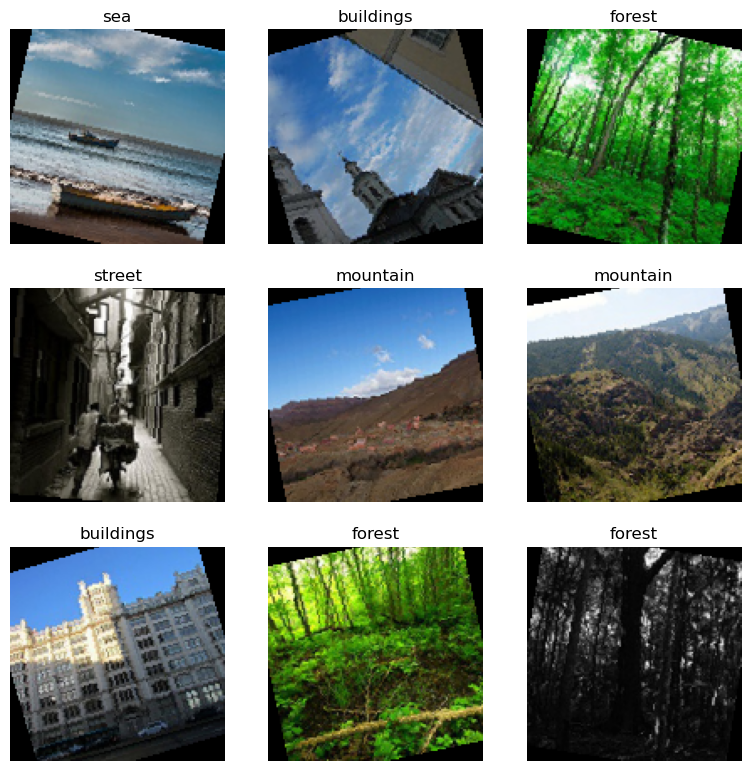

In [10]:
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(class_names[labels[i]],fontdict={'fontsize': 12})
plt.tight_layout()

In [11]:
@torch.no_grad()
def showImage(img,model):
    model.eval()
    img = img.to(device)
    pred = model(img)
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().numpy()
    pred = np.squeeze(pred)
    plt.imshow(pred)
    
    plt.axis('off')
    plt.show()

# Creating model

In [12]:
class convBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1):
        super(convBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [13]:
# ConvBlock test
sambpleConvBlock = convBlock(3, 64)
tmp = sambpleConvBlock(images)
tmp.shape

torch.Size([32, 64, 64, 64])

# Model fitting

# Evaluation